<a id="top"></a>

# 02 — Codificación **offline** a H5 (formato v2)

Convierte los *splits* CSV (`train/val/test`) preparados en `01_DATA_QC_PREP` (y, si lo usaste, `01A_PREP_BALANCED`) a archivos **H5** ya codificados temporalmente. Esto acelera el entrenamiento cuando los presets usan `use_offline_spikes: true` y `encode_runtime: false`.

**Qué hace este notebook**
- Lee los CSV de `data/processed/<run>/{train,val,test}.csv`.
- Aplica un codificador temporal (`rate` | `latency` | `raw`) con parámetros `T`, `gain`, `size`, `gray/rgb`.
- Escribe H5 con **formato v2** estable y auto-descriptivo (atributos + datasets).

---

## ✅ Prerrequisitos
- Haber generado los CSV con `01_DATA_QC_PREP.ipynb` (y opcionalmente `01A_PREP_BALANCED.ipynb`).
- Estructura esperada:
    - `data/raw/udacity/<run>/IMG/...`
    - `data/processed/<run>/{train.csv, val.csv, test.csv}`


**Salidas**
- `data/processed/<run>/<split>_<encoder>_T<T>_gain<G>_<gray|rgb>_<W>x<H>.h5`
- Los H5 **no** tocan `prep_manifest.json` (solo lectura de CSV).

<a id="toc"></a>

## 🧭 Índice

- [1) Configuración de codificación (parámetros y rutas)](#sec-01)
- [2) Generación de H5 para todos los `RUNS × SPLITS`](#sec-02)
- [3) Inspección QC de un H5 (atributos, formas y proyección)](#sec-03)


<a id="sec-01"></a>

## 1) Configuración de la **codificación offline** a H5

**Objetivo del notebook:** convertir los *splits* CSV (`train/val/test`) generados en la preparación (01_DATA_QC_PREP o 01A_PREP_BALANCED) a **H5 codificados temporalmente** (formato v2) para acelerar el entrenamiento.

**Qué define esta celda**
- Rutas base del repo (`ROOT`) y módulos necesarios.
- Parámetros de codificación:
  - `RUNS`: recorridos a procesar (p. ej., `["circuito1", "circuito2"]`).
  - `SPLITS`: por defecto `["train", "val", "test"]`.
  - `ENCODER`: `"rate" | "latency" | "raw"`.
  - `T`, `GAIN` (solo aplica a `rate`), `SIZE=(W,H)`, `TO_GRAY`, `SEED`.
- Directorios:  
  `RAW_ROOT = data/raw/udacity`, `PROC_ROOT = data/processed`.

**Requisitos previos**
- Haber ejecutado **01_DATA_QC_PREP** (y, si corresponde, **01A_PREP_BALANCED**) para obtener:
  - `data/processed/<run>/{train,val,test}.csv`
  - (Opcional) `train_balanced.csv` (no usado aquí salvo que lo adaptes).

**Salida esperada**
- Variables listas para lanzar la conversión en la siguiente celda.

[↑ Volver al índice](#toc)

In [1]:
# =============================================================================
# Imports & params (desde presets.yaml)
# =============================================================================
from pathlib import Path
import sys, json
import pandas as pd  # opcional, por si inspeccionas algo

ROOT = Path.cwd().parents[0] if (Path.cwd().name == "notebooks") else Path.cwd()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from src.utils import load_preset
from src.prep.encode_offline import encode_csv_to_h5

# --- Lee preset ---
PRESET = "fast"  # fast | std | accurate
CFG = load_preset(ROOT / "configs" / "presets.yaml", PRESET)

# --- Params de modelo/datos (robustos) ---
ENCODER = str(CFG["data"]["encoder"])
T       = int(CFG["data"]["T"])
GAIN    = float(CFG["data"]["gain"])
SIZE    = (int(CFG["model"]["img_w"]), int(CFG["model"]["img_h"]))  # (W, H)
TO_GRAY = bool(CFG["model"]["to_gray"])
SEED    = int(CFG["data"]["seed"])

# --- Rutas base ---
RAW_ROOT  = ROOT / "data" / "raw" / "udacity"
PROC_ROOT = ROOT / "data" / "processed"

# --- Selección de fichero de tasks según preset ---
USE_BALANCED = bool(CFG.get("prep_offline", {}).get("use_balanced_tasks", False))
tasks_balanced_name = (CFG.get("prep", {}).get("tasks_balanced_file_name") or "tasks_balanced.json")
tasks_plain_name    = (CFG.get("prep", {}).get("tasks_file_name") or "tasks.json")

candidate = PROC_ROOT / (tasks_balanced_name if USE_BALANCED else tasks_plain_name)
if candidate.exists():
    TASKS_PATH = candidate
else:
    # Fallback sensato a tasks.json si el balanced no existe
    fallback = PROC_ROOT / tasks_plain_name
    if candidate != fallback:
        print(f"[WARN] No existe {candidate.name}; usando {fallback.name} en su lugar.")
    TASKS_PATH = fallback

TASKS  = json.loads(TASKS_PATH.read_text(encoding="utf-8"))
RUNS   = TASKS["tasks_order"]
SPLITS = ["train", "val", "test"]

# --- Echo de configuración efectiva ---
print(f"[PRESET={PRESET}] encoder={ENCODER} T={T} gain={GAIN} | size={SIZE} gray={TO_GRAY} | seed={SEED}")
print("Usando tasks:", TASKS_PATH.name, "| balanced:", USE_BALANCED)
print("RUNS:", RUNS)


[PRESET=fast] encoder=rate T=10 gain=0.5 | size=(200, 66) gray=True | seed=42
Usando tasks: tasks_balanced.json | balanced: True
RUNS: ['circuito1', 'circuito2']


<a id="sec-02"></a>

## 2) Generación de H5 (formato **v2**) para todos los RUNS × SPLITS

**Qué hace**
- Recorre cada `run` en `RUNS` y cada `split` en `SPLITS`.
- Comprueba que existan las carpetas y los CSV correspondientes.
- Llama a `encode_csv_to_h5(...)` para producir un `.h5` con **nomenclatura estable**: `<split>_<encoder>T<T>gain<g><gray|rgb><W>x<H>.h5`

> Nota: si `ENCODER != "rate"`, el sufijo de `gain` queda como `gain0` (convención).

**Formato H5 v2 generado**
- Atributos: `version=2`, `encoder`, `T`, `gain`, `size_wh=[W,H]`, `to_gray`, `channels`.
- Datasets:
- `/spikes`:  
  - gris → `(N, T, H, W)`  
  - RGB  → `(N, T, C, H, W)`
- `/steering`: `(N,)`
- `/filenames`: `(N,)` con rutas relativas para trazabilidad
- Tipos:
- `rate/raw` → `uint8`
- `latency`  → `float32`

**Consejos**
- Si vas a rehacer los H5 con otros parámetros (p. ej. otro `T`), no necesitas borrar manualmente: el **nombre de salida** cambia y no se pisan archivos existentes.
- Si quieres forzar el *overwrite*, bórralos explícitamente o usa la utilidad CLI `tools/encode_tasks.py` con `--force`.

**Salida esperada**
- H5 por cada combinación (`run`, `split`) impreso como `OK: ...`.
- `SAMPLE_OUT` apuntando al **primer** H5 generado para inspección en la siguiente celda.

[↑ Volver al índice](#toc)


In [2]:
# =============================================================================
# Generar H5 para todos los RUNS x SPLITS (formato "oficial" v2)
# =============================================================================
SAMPLE_OUT = None
color_tag = "gray" if TO_GRAY else "rgb"
gain_tag  = GAIN if ENCODER == "rate" else 0
W, H = SIZE

for run in RUNS:
    base   = RAW_ROOT / run
    outdir = PROC_ROOT / run
    outdir.mkdir(parents=True, exist_ok=True)
    assert base.exists(), f"No existe carpeta de imágenes: {base}"

    paths = TASKS["splits"][run]
    for split in SPLITS:
        csv = Path(paths[split])
        if not csv.is_absolute():
            csv = ROOT / csv
        assert csv.exists(), f"No existe CSV: {csv}"

        out = outdir / f"{split}_{ENCODER}_T{T}_gain{gain_tag}_{color_tag}_{W}x{H}.h5"

        encode_csv_to_h5(
            csv_df_or_path=csv,
            base_dir=base,
            out_path=out,
            encoder=ENCODER,
            T=T,
            gain=GAIN,
            size_wh=(W, H),
            to_gray=TO_GRAY,
            seed=SEED
        )
        print("OK:", out)

        if SAMPLE_OUT is None:
            SAMPLE_OUT = out

print("\nHecho. Ejemplo de salida:", SAMPLE_OUT)


OK: /home/cesar/proyectos/TFM_SNN/data/processed/circuito1/train_rate_T10_gain0.5_gray_200x66.h5
OK: /home/cesar/proyectos/TFM_SNN/data/processed/circuito1/val_rate_T10_gain0.5_gray_200x66.h5
OK: /home/cesar/proyectos/TFM_SNN/data/processed/circuito1/test_rate_T10_gain0.5_gray_200x66.h5
OK: /home/cesar/proyectos/TFM_SNN/data/processed/circuito2/train_rate_T10_gain0.5_gray_200x66.h5
OK: /home/cesar/proyectos/TFM_SNN/data/processed/circuito2/val_rate_T10_gain0.5_gray_200x66.h5
OK: /home/cesar/proyectos/TFM_SNN/data/processed/circuito2/test_rate_T10_gain0.5_gray_200x66.h5

Hecho. Ejemplo de salida: /home/cesar/proyectos/TFM_SNN/data/processed/circuito1/train_rate_T10_gain0.5_gray_200x66.h5


<a id="sec-03"></a>

## 3) Inspección rápida del H5 generado (formato v2)

**Qué hace**
- Abre `SAMPLE_OUT` (primer H5 creado en la celda anterior).
- Imprime:
  - Atributos del archivo (verifica `version=2`, `encoder`, `T`, etc.).
  - Datasets disponibles (`spikes`, `steering`, `filenames`).
  - Formas y tipos de datos (`spikes.shape`, `steering.shape`).
- Muestra una **proyección acumulada** del primer ejemplo:
  - gris: suma en el eje temporal → `T × H × W → H × W`
  - RGB: suma en `T` y `C` → `T × C × H × W → H × W`
- Renderiza la proyección como imagen (QC visual).

**Cómo interpretarlo**
- En `rate/raw` (binario), la proyección suma “actividad” por píxel.
- En `latency` (float32), corroboras que los valores sigan la convención del codificador (latencias/-1).
- Verifica que el `W×H` y el modo (`gray/rgb`) coinciden con tus parámetros.

**Siguientes pasos**
- Si el QC es correcto, puedes poner en el preset:
  - `use_offline_spikes=true`
  - `encode_runtime=false`
  y apuntar tus *runners* a estos H5 para acelerar la E/S en entrenamiento.

[↑ Volver al índice](#toc)

Mostrando: /home/cesar/proyectos/TFM_SNN/data/processed/circuito1/train_rate_T10_gain0.5_gray_200x66.h5
Atributos:
 - T: 10
 - channels: 1
 - encoder: rate
 - gain: 0.5
 - size_wh: [200  66]
 - to_gray: 1
 - version: 2
Datasets: ['filenames', 'spikes', 'steering']
spikes: (126861, 10, 66, 200) uint8 | steering: (126861,) float32


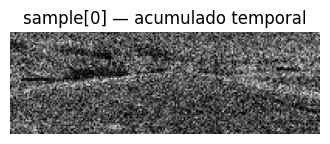

In [3]:
# Inspección del H5 (formato oficial v2)
import h5py, numpy as np, matplotlib.pyplot as plt

assert SAMPLE_OUT is not None, "No se generó ningún H5 en la celda anterior."
print("Mostrando:", SAMPLE_OUT)

def _proj_img(x):
    # (T,H,W) -> acumula T; (T,C,H,W) -> acumula T y C
    if x.ndim == 2:
        return x
    if x.ndim == 3:
        return x.sum(axis=0)
    if x.ndim == 4:
        return x.sum(axis=(0,1))
    raise ValueError(x.shape)

with h5py.File(SAMPLE_OUT, "r") as h5:
    print("Atributos:")
    for k, v in h5.attrs.items():
        print(f" - {k}: {v}")
    print("Datasets:", list(h5.keys()))

    X = h5["spikes"]
    y = h5["steering"]
    print("spikes:", X.shape, X.dtype, "| steering:", y.shape, y.dtype)

    # primera muestra
    x0 = X[0]  # (T,H,W) o (T,C,H,W)
    acc = _proj_img(x0)

plt.figure(figsize=(4, 3))
plt.imshow(acc, cmap="gray")
plt.title("sample[0] — acumulado temporal")
plt.axis("off")
plt.show()
